Using device: cuda


100%|██████████| 170M/170M [01:20<00:00, 2.12MB/s]


Starting training...
Epoch [1/10], Step [200/782], Loss: 2.2251, Accuracy: 16.61%
Epoch [1/10], Step [400/782], Loss: 1.9813, Accuracy: 25.38%
Epoch [1/10], Step [600/782], Loss: 1.8169, Accuracy: 31.12%
Epoch [2/10], Step [200/782], Loss: 1.6611, Accuracy: 37.03%
Epoch [2/10], Step [400/782], Loss: 1.5951, Accuracy: 39.95%
Epoch [2/10], Step [600/782], Loss: 1.5569, Accuracy: 41.60%
Epoch [3/10], Step [200/782], Loss: 1.4869, Accuracy: 44.65%
Epoch [3/10], Step [400/782], Loss: 1.4569, Accuracy: 45.84%
Epoch [3/10], Step [600/782], Loss: 1.4243, Accuracy: 47.10%
Epoch [4/10], Step [200/782], Loss: 1.3544, Accuracy: 51.04%
Epoch [4/10], Step [400/782], Loss: 1.3332, Accuracy: 51.48%
Epoch [4/10], Step [600/782], Loss: 1.3177, Accuracy: 51.88%
Epoch [5/10], Step [200/782], Loss: 1.2583, Accuracy: 54.22%
Epoch [5/10], Step [400/782], Loss: 1.2428, Accuracy: 55.10%
Epoch [5/10], Step [600/782], Loss: 1.2126, Accuracy: 56.12%
Epoch [6/10], Step [200/782], Loss: 1.1911, Accuracy: 57.31%
Epo

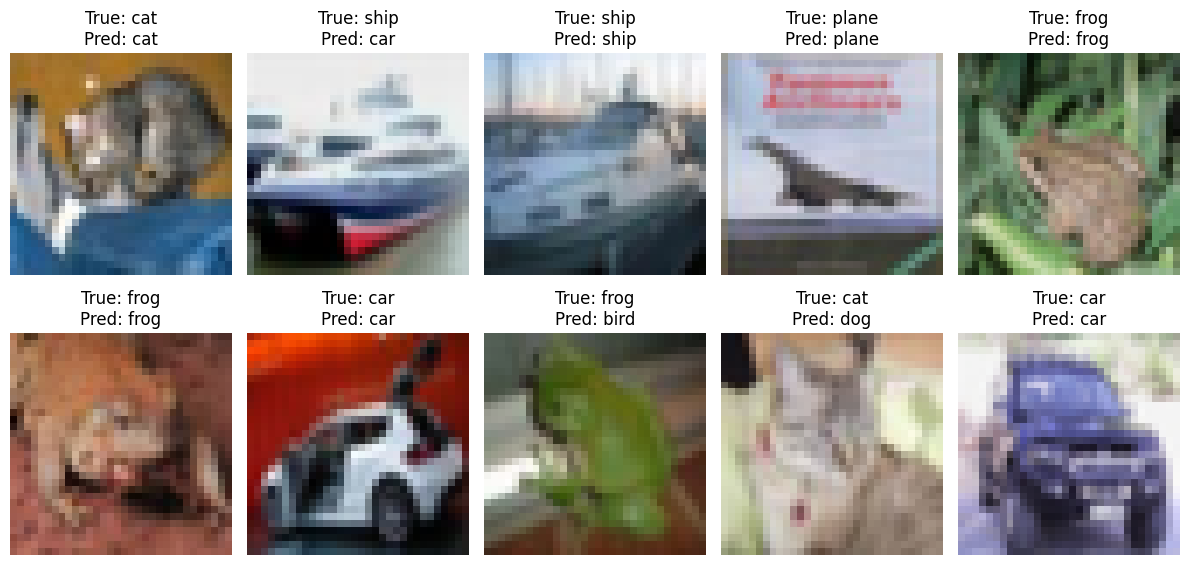

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10
num_classes = 10

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN Architecture
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNeuralNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        # Activation and Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Conv Block 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # 32x32 -> 16x16

        # Conv Block 2
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 16x16 -> 8x8

        # Conv Block 3
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)  # 8x8 -> 4x4

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Initialize model, loss function, and optimizer
model = ConvNeuralNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            # Print statistics
            if (i + 1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                      f'Loss: {running_loss/200:.4f}, Accuracy: {100*correct/total:.2f}%')
                running_loss = 0.0
                correct = 0
                total = 0

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Train the model
print("Starting training...")
train_model(model, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model
print("\nEvaluating model...")
test_accuracy = evaluate_model(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'cnn_cifar10.pth')
print("Model saved successfully!")

# Visualize predictions
def visualize_predictions(model, test_loader, classes, num_images=10):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    # Display images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for idx in range(num_images):
        ax = axes[idx // 5, idx % 5]
        img = images[idx].cpu().numpy().transpose(1, 2, 0)
        img = img * 0.5 + 0.5  # Denormalize
        ax.imshow(img)
        ax.set_title(f'True: {classes[labels[idx]]}\nPred: {classes[predictions[idx]]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
visualize_predictions(model, test_loader, classes)


Using device: cuda
